In [38]:
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = 16, 6
import numpy as np
import ipywidgets

# Skin Detection

Many papers deal with the issue of skin color modelling. Some attempt to generalize a global skin color from a training set that covers all races and lighting conditions. Such global models may suffer from overgeneralization on one hand and inability to handle camera adjustment (e.g. white balance) on the other. 

A more suitable approach is to use a known source of skin color in the image, such as a persons face, to generalize skin color in the rest of the image [[1]](https://www.robots.ox.ac.uk/~vgg/publications/2011/Mittal11/mittal11.pdf). Lets apply our knowledge about HSV colorspace, face detection and back-projection. First lets find a face:

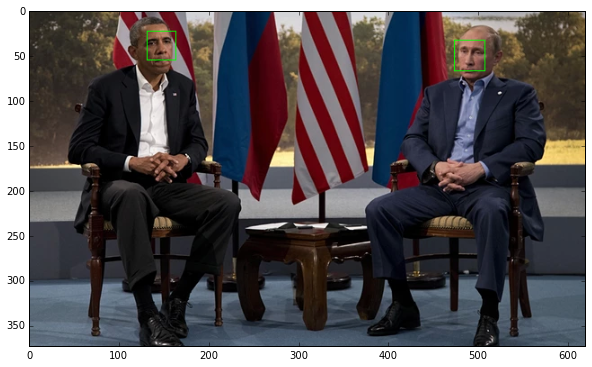

In [39]:
import cv2
img_bgr = cv2.imread('meet.png')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
rects = face_cascade.detectMultiScale(img_bgr, minSize=(24,24), maxSize=(36, 36), scaleFactor=1.1, minNeighbors=2) 
canvas = np.array(img_rgb)
for rect in rects:
    cv2.rectangle(canvas, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0,255,0))
imshow(canvas);

Now lets extract a hue color histogram from it

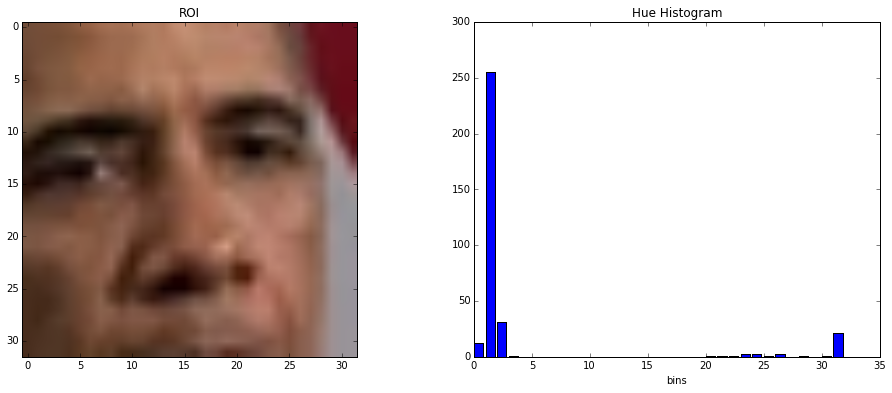

In [40]:
#from_x,from_y,to_x,to_y = 125,19,153,64 # Obama's face
#from_x,from_y,to_x,to_y = 480,32,506,72  # Putin's face
rect = rects[0]
from_x,from_y,to_x,to_y = rect[0],rect[1],rect[0]+rect[2],rect[1]+rect[3]

subplot(121); imshow(img_rgb[from_y:to_y,from_x:to_x]); title('ROI')

img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
hue_hist = cv2.calcHist([img_hsv[from_y:to_y,from_x:to_x]], [0], None, [32], [0, 180])
cv2.normalize(hue_hist, hue_hist, 0, 255, cv2.NORM_MINMAX)
subplot(122); bar(range(len(hue_hist)), hue_hist); title('Hue Histogram'); xlabel('bins');


Lets backproject the face skin model and see how well it generalizes to the hands.

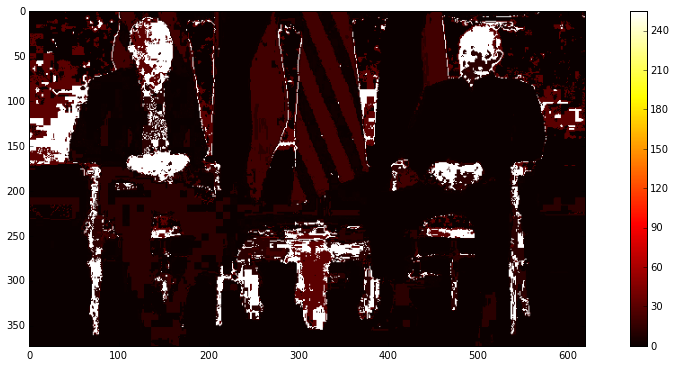

In [41]:
prob = cv2.calcBackProject([img_hsv], [0], hue_hist, [0, 180],1)
imshow(prob, cmap='hot'); colorbar();

We can see that using only hue is enough to recall all palm pixels, it also has the downside of including background pixels as well, leading to low precision.

## 2D histogram

We saw that non-skin color was also classified as skin color since they share the same hue. To distinguish them we add another dimension: saturation. The following is a 2D histogram based on hue and saturation:

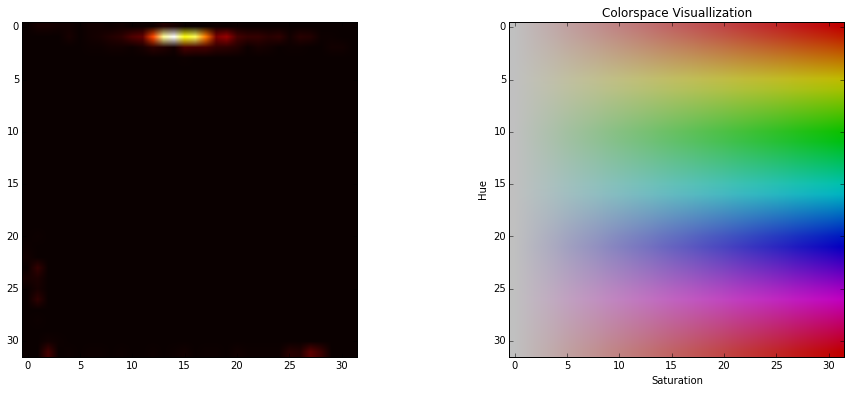

In [42]:
hs_hist = cv2.calcHist([img_hsv[from_y:to_y,from_x:to_x]], [0,1], None, [32,32], [0, 180,0, 255])
cv2.normalize(hs_hist, hs_hist, 0, 255, cv2.NORM_MINMAX)
subplot(121); imshow(hs_hist, cmap='hot');

# Visualize the hue saturation space
colormap_hsv = np.ones((32,32,3), np.uint8)*192
colormap_hsv[:,:,1],colormap_hsv[:,:,0] = np.meshgrid(np.linspace(0, 255, 32), np.linspace(0, 180, 32))
colormap_rgb = cv2.cvtColor(colormap_hsv, cv2.COLOR_HSV2RGB)
subplot(122); imshow(colormap_rgb); title('Colorspace Visuallization'); xlabel('Saturation'); ylabel('Hue');

Backprojecting the 2d histogram shows a significantly more precise detection:

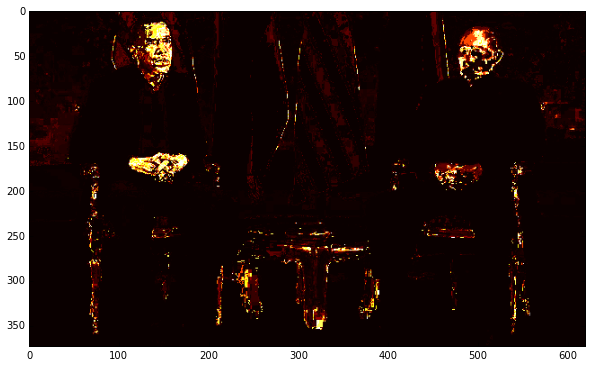

In [43]:
hs_prob = cv2.calcBackProject([img_hsv], [0,1], hs_hist, [0, 180,0, 255],1)
imshow(hs_prob, cmap='hot');

## Masking
Dark pixels carry very little chromatic information, most of it is due to noise. This is also true for low saturation colors which are essentially gray. In practice we might be better off ignoring these monochromatic values in our color model. One way to accomplish this is by masking.

For example, the following creates a mask which ignores dark pixels ($value<32$) and unsaturated pixels ($saturation<60$):

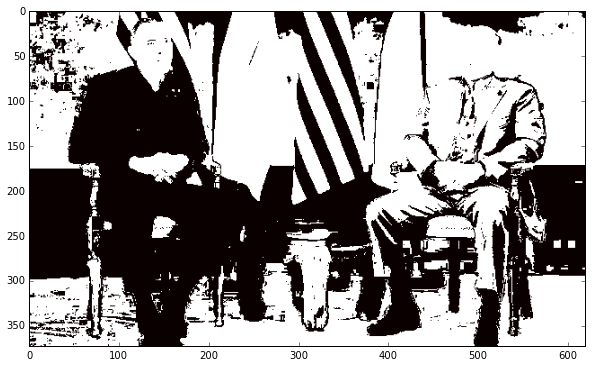

In [44]:
mask = cv2.inRange(img_hsv, np.array((0., 60., 32.)), np.array((180., 255., 255.)))
imshow(mask, cmap='hot');

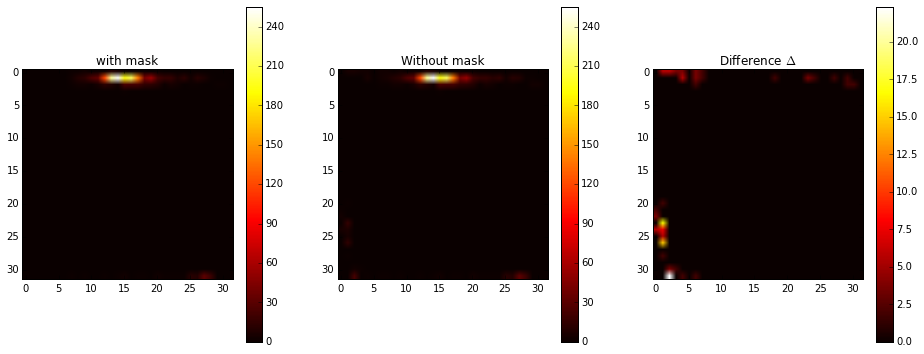

In [45]:
masked_hs_hist = cv2.calcHist([img_hsv[from_y:to_y,from_x:to_x]], [0,1], mask[from_y:to_y,from_x:to_x], [32,32], [0, 180,0, 255])
cv2.normalize(masked_hs_hist, masked_hs_hist, 0, 255, cv2.NORM_MINMAX)
subplot(131); imshow(masked_hs_hist, cmap='hot'); title('with mask');colorbar()
subplot(132); imshow(hs_hist, cmap='hot'); title('Without mask');colorbar()
subplot(133); imshow(hs_hist-masked_hs_hist, cmap='hot'); title('Difference $\Delta$');colorbar();

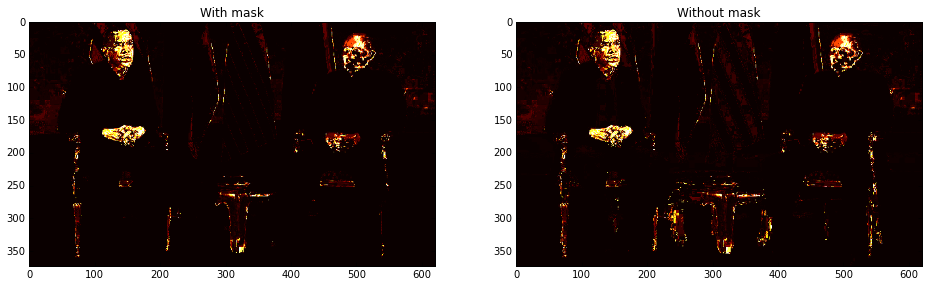

In [46]:
masked_hs_prob = cv2.calcBackProject([img_hsv], [0,1], masked_hs_hist, [0, 180,0, 255],1)
cv2.bitwise_and(masked_hs_prob, mask, dst=masked_hs_prob)
subplot(121);title('With mask');imshow(masked_hs_prob, cmap='hot')
subplot(122);title('Without mask');imshow(hs_prob, cmap='hot');

## Binary Skin Image
Finally, to obtain the binary skin image we must apply a threshold to the data using **cv2.threshold**:

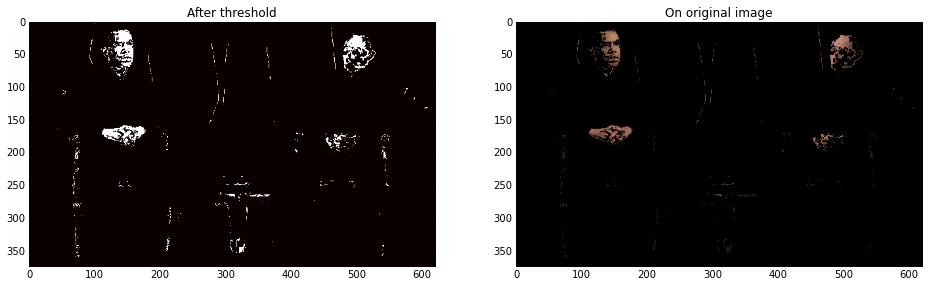

In [47]:
_, img = cv2.threshold(masked_hs_prob, 64, 255, cv2.CV_8U)
subplot(121); imshow(img, cmap='hot'); title('After threshold')
subplot(122); imshow(cv2.bitwise_and(np.dstack((img,img,img)), img_rgb)); title('On original image'); 